<a href="https://colab.research.google.com/github/durml91/MMath-Project/blob/duo-branch/Diffusion_RL/new_diff_QL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install einops
!pip install equinox
!pip install optax
!pip install diffrax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 762.2 kB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 KB 8.7 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 2.7.1
    Uninstalling typeguard-2.7.1:
      Successfully uninstalled typeguard-2.7.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 KB 12.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 KB 9.3 MB/s eta 0:00:00


In [2]:
import array
import functools as ft
import gzip
import os
import struct
import urllib.request

import diffrax as dfx  # https://github.com/patrick-kidger/diffrax
import einops  # https://github.com/arogozhnikov/einops
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

import equinox as eqx
import numpy as np

In [3]:
key = jr.PRNGKey(2023)

Data generation

In [4]:
def Gaussian(N, mu, sigma, key):
    sg = jr.normal(key, shape=(N,2))
    g = mu + sigma * sg
    return g

In [5]:
mean1 = jnp.array((0.0, 0.8))
mean2 = jnp.array((0.0, -0.8))
mean3 = jnp.array((0.8, 0.0))
mean4 = jnp.array((-0.8, 0.0))
std = jnp.array((0.05, 0.05))

In [6]:
s1 = Gaussian(2500, mean1, std, key)
s2 = Gaussian(2500, mean2, std, key)
s3 = Gaussian(2500, mean3, std, key)
s4 = Gaussian(2500, mean4, std, key)

In [7]:
samples = jnp.concatenate([s1, s2, s3, s4], axis=0)

In [ ]:
import matplotlib.pyplot as plt

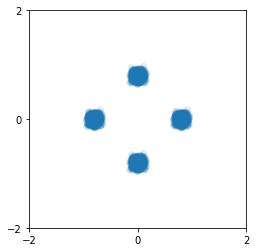

In [ ]:
plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.1) #plot 1st row as x values and 2nd row as y values on the plot
plt.xticks([-2, 0, 2])
plt.yticks([-2, 0, 2])
plt.show()

Add reward

In [8]:
def rewGau(N, mu, sigma, key):
    sg = jr.normal(key, shape=(N,1))
    g = mu + sigma * sg
    return g

In [9]:
r1 = rewGau(2500, 5.0, 0.5, key)
r2 = rewGau(2500, 10.0, 0.5, key)
r3 = rewGau(2500, 2.0, 0.5, key)
r4 = rewGau(2500, 0.0, 0.5, key)

In [10]:
rewards = jnp.concatenate([r1, r2, r3, r4], axis=0)

In [ ]:
rewards.shape

(10000, 1)

Join actions and rewards

In [11]:
comb = jnp.concatenate([samples, rewards], axis=1)

In [ ]:
comb[0]

Array([0.0330051, 0.7809029, 2.9173243], dtype=float32)

In [ ]:
rewards[:,0]

(10000,)

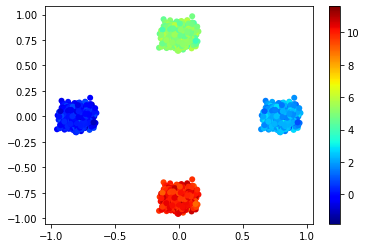

In [ ]:
points = plt.scatter(samples[:, 0], samples[:, 1], c=rewards[:,0 ],cmap="jet", lw=0)
plt.colorbar(points)

Helper Functions

In [12]:
from typing import Callable

class Lambda1(eqx.Module):
    fn: Callable
    
    def __call__(self, x, *, key=None):
        return x * jnp.tanh(self.fn(x))

In [ ]:
# class SinusoidalTimEmb(eqx.Module):
#     dim: int
#     def __init__ (self, dim):
#         self.dim = dim

#     def __call__ (self, x):
#           half_dim = self.dim // 2
#           emb = jnp.log(10000) / (half_dim - 1)
#           emb = jnp.exp(jnp.arange(half_dim) * - emb)
#           emb = x[:, None] * emb[None, :]
#           emb = jnp.concatenate([jnp.sin(emb), jnp.cos(emb)], axis=-1)
#           return emb

Networks

In [12]:
class ActorNet(eqx.Module):
  main_net: eqx.nn.MLP
  t1: float

  def __init__(self, in_size, out_size, hidden_size, depth, key):
    (rng,) = jr.split(key, 1)
    self.main_net = eqx.nn.MLP(in_size, out_size , hidden_size, depth, key = rng)
    self.t1 = t1

  def __call__(self, t, y):
    t = t / self.t1
    t = einops.repeat(t, "-> 2")
    y = jnp.concatenate([y, t]) #axis =1
    
    y = self.main_net(y)
    return y

In [13]:
class Critic1Net(eqx.Module):
    Mlp: eqx.nn.MLP

    def __init__(self, in_size, out_size, depth, hidden_size, key):
        self.Mlp = eqx.nn.MLP(in_size, out_size, hidden_size, depth, key=key)

    def __call__(self, x):
      return self.Mlp(x)

In [14]:
class Critic2Net(eqx.Module):
    Mlp: eqx.nn.MLP

    def __init__(self, in_size, out_size, depth, hidden_size, key):
        self.Mlp = eqx.nn.MLP(in_size, out_size, hidden_size, depth, key=key)

    def __call__(self, x):
      return self.Mlp(x)

In [ ]:
# class ActorNet(eqx.Module):

#     time_mlp: eqx.nn.Sequential
#     mid_layer: eqx.nn.Sequential
#     final_layer: eqx.nn.Linear
#     t_dim: int = 16
#     t1: float
#     t_embed: eqx.Module

#     def __init__ (self, *, key,):

#         keya, keyb, keyc, keyd, keye, keyf = jr.split(key, 6)
 
#         t_dim = self.t_dim
#         self.t_embed = SinusoidalTimEmb(t_dim)
#         self.time_mlp = eqx.nn.Sequential([
#             eqx.nn.Linear(t_dim, t_dim *2, key=keya),
#             Lambda1(jax.nn.softplus),
#             eqx.nn.Linear(t_dim * 2, t_dim, key=keyb)   
#         ])
        
#         input_dim = 2 + t_dim

#         self.mid_layer = eqx.nn.Sequential([
#             eqx.nn.Linear(input_dim ,256, key=keyc),
#             Lambda1(jax.nn.softplus),
#             eqx.nn.Linear(256, 256, key=keyd),
#             Lambda1(jax.nn.softplus),
#             eqx.nn.Linear(256, 256, key=keye),
#             Lambda1(jax.nn.softplus)
#         ])

#         self.final_layer = eqx.nn.Linear(256, 2, key=keyf)

#         self.t1 = t1

#     def __call__(self, t, x):
#         t = jnp.array([t])
#         new_t = t/self.t1
#         input = self.t_embed(new_t)
#         input = jnp.squeeze(input)
#         t = self.time_mlp(input)
#         x = jnp.concatenate([x, t], axis=-1)
#         x = self.mid_layer(x)

#         return self.final_layer(x)

In [14]:
# class Critic1Net(eqx.Module):
#   mlp: eqx.nn.Sequential

#   def __init__(self, in_size, out_size, hidden_size, key):  #hidden_size = 256
#     keya, keyb, keyc, keyd = jr.split(key, 4)
#     self.mlp = eqx.nn.Sequential([eqx.nn.Linear(in_size, hidden_size, key=keya),
#                                   Lambda1(jax.nn.softplus),
#                                   eqx.nn.Linear(hidden_size, hidden_size, key=keyb),
#                                   Lambda1(jax.nn.softplus),
#                                   eqx.nn.Linear(hidden_size, hidden_size, key=keyc),
#                                   Lambda1(jax.nn.softplus),
#                                   eqx.nn.Linear(hidden_size, out_size, key=keyd)])
#   def __call__(self, x):
#     return self.mlp(x)

In [15]:
# class Critic2Net(eqx.Module):
#   mlp: eqx.nn.Sequential

#   def __init__(self, in_size, out_size, hidden_size, key):  #hidden_size = 256
#     keya, keyb, keyc, keyd = jr.split(key, 4)
#     self.mlp = eqx.nn.Sequential([eqx.nn.Linear(in_size, hidden_size, key=keya),
#                                   Lambda1(jax.nn.softplus),
#                                   eqx.nn.Linear(hidden_size, hidden_size, key=keyb),
#                                   Lambda1(jax.nn.softplus),
#                                   eqx.nn.Linear(hidden_size, hidden_size, key=keyc),
#                                   Lambda1(jax.nn.softplus),
#                                   eqx.nn.Linear(hidden_size, out_size, key=keyd)])
#   def __call__(self, x):
#     return self.mlp(x)

Target Functions

In [15]:
def ema(new_weight: jax.Array, target_weight: jax.Array, beta: float) -> jax.Array:
  update_w = target_weight * beta + (1 - beta)* new_weight
  return update_w


def EMA_w_update(current_model, target_model, init_fn, beta):
  is_linear = lambda x: isinstance(x, eqx.nn.Linear)
  
  get_weights = lambda m: [x.weight
                           for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                           if is_linear(x)]
  new_weights = get_weights(current_model)

  target_weights = get_weights(target_model)

  updated_weights = [init_fn(n_weight, t_weight, beta) for n_weight, t_weight in zip(new_weights, target_weights)]
  new_model = eqx.tree_at(get_weights, target_model, updated_weights)

  return new_model


def EMA_b_update(current_model, target_model, init_fn, beta):
  is_linear = lambda x: isinstance(x, eqx.nn.Linear)
  get_biases = lambda m: [x.bias
                          for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                          if is_linear(x)]
  new_biases = get_biases(current_model)
  target_biases = get_biases(target_model)
  updated_biases = [init_fn(c_bias, t_bias, beta) for c_bias, t_bias in zip(new_biases, target_biases)]
  new_model = eqx.tree_at(get_biases, target_model, updated_biases)

  return new_model

In [16]:
def single_loss_fn(model, weight, int_beta, data, t, key):
    mean = data * jnp.exp(-0.5 * int_beta(t))
    var = jnp.maximum(1 - jnp.exp(-int_beta(t)), 1e-5)
    std = jnp.sqrt(var)
    noise = jr.normal(key, data.shape)
    y = mean + std * noise
    pred = model(t, y)
    return weight(t) * jnp.mean((pred + noise / std) ** 2)

In [17]:
def batch_loss_fn(model, weight, int_beta, data, t1, key):
    batch_size = data.shape[0]
    tkey, losskey = jr.split(key)
    losskey = jr.split(losskey, batch_size)
    # Low-discrepancy sampling over t to reduce variance
    t = jr.uniform(tkey, (batch_size,), minval=0, maxval=t1 / batch_size)
    t = t + (t1 / batch_size) * jnp.arange(batch_size)
    loss_fn = ft.partial(single_loss_fn, model, weight, int_beta)
    loss_fn = jax.vmap(loss_fn)
    return jnp.mean(loss_fn(data, t, losskey))

In [18]:
@eqx.filter_jit
def single_sample_fn(model, int_beta, data_shape, dt0, t1, key):
    def drift(t, y, args):
        _, beta = jax.jvp(int_beta, (t,), (jnp.ones_like(t),))
        return -0.5 * beta * (y + model(t, y))

    term = dfx.ODETerm(drift)
    solver = dfx.Tsit5()
    t0 = 0
    y1 = jr.normal(key, data_shape)
    # reverse time, solve from t1 to t0
    sol = dfx.diffeqsolve(term, solver, t1, t0, -dt0, y1)
    return sol.ys[0]

Parameters

In [19]:
iterations = 20_000  #100
data = comb
batch_size = 256
t1 = 10.0
dt0 = 0.1
data_shape  = (2,)
discount = 0.99
lr = 3e-4
eta = 1.0  #q learning weight
grad_norm = 1.0
update_ema_every = 5
step_start_ema = 1000
beta = 0.995  #update policy network parameter
#tau = 0.005   #update critic network parameter

In [20]:
int_beta = lambda t: t
weight = lambda t: 1 - jnp.exp(-int_beta(t))  

Initilialisations

In [21]:
key1, key2, key3 = jr.split(key, 3)

In [22]:
c_Q1 = Critic1Net(2, 1, 4, 256, key1)
t_Q1 = Critic1Net(2, 1, 4, 256, key1)


c_Q2 = Critic2Net(2, 1, 4, 256, key2)
t_Q2 = Critic2Net(2, 1, 4, 256, key2)

In [23]:
c_pi = ActorNet(4, 2, 256, 4, key=key3)
t_pi = ActorNet(4, 2, 256, 4, key=key3)

In [24]:
clip = optax.clip_by_global_norm(1.0)

a_opt = optax.adabelief(lr)
Q_opt= optax.chain(clip, a_opt)

opt_state_cQ1 = Q_opt.init(eqx.filter(c_Q1, eqx.is_inexact_array))

opt_state_cQ2 = Q_opt.init(eqx.filter(c_Q2, eqx.is_inexact_array))



b_opt = optax.adabelief(lr)
pi_opt= optax.chain(clip, b_opt)

opt_state_pi = pi_opt.init(eqx.filter(c_pi, eqx.is_inexact_array))

Train

In [25]:
def critic_loss(c_Qa, c_Qb, t_pi, t_Q1, t_Q2, action, reward, n_act_key):
    current_qa = jax.vmap(c_Qa)(action)
    current_qb = jax.vmap(c_Qb)(action)
    
    alpha_key = jr.split(n_act_key, batch_size)
    sample_fn = ft.partial(single_sample_fn, t_pi, int_beta, data_shape , dt0, t1)
    next_action = jax.vmap(sample_fn)(alpha_key)

    t_1 = jax.vmap(t_Q1)(next_action)
    t_2 = jax.vmap(t_Q2)(next_action)
  
    target_q = jnp.minimum(t_1, t_2)
    
    target_q = jax.lax.stop_gradient(reward + (discount * target_q))
    
    return jnp.mean( ( current_qa - target_q )**2) + jnp.mean( ( current_qb - target_q )**2)

In [26]:
def critic_update(c_Q1, c_Q2, t_pi, t_Q1, t_Q2, action, reward, n_act_key, opt_state_1, opt_state_2):
    loss_fn = eqx.filter_value_and_grad(critic_loss)
    
    loss1, grads1 = loss_fn(c_Q1, c_Q2, t_pi, t_Q1, t_Q2, action, reward, n_act_key)
    loss2, grads2 = loss_fn(c_Q2, c_Q1, t_pi, t_Q1, t_Q2, action, reward, n_act_key)

    updates1, opt_state_1 = Q_opt.update(grads1, opt_state_1)

    updates2, opt_state_2 = Q_opt.update(grads2, opt_state_2)
    
    c_Q1 = eqx.apply_updates(c_Q1, updates1)
    c_Q2 = eqx.apply_updates(c_Q2, updates2)

    n_act_key = jr.split(n_act_key, 1)[0]

    return loss1, loss2, c_Q1, c_Q2, n_act_key, opt_state_1, opt_state_2

In [27]:
def actor_loss(c_pi, c_Q1, c_Q2, action, u_key, p_act_key, actor_key):
    beta_key = jr.split(p_act_key, batch_size)
    sample_fn = ft.partial(single_sample_fn, c_pi, int_beta, data_shape , dt0, t1)
    new_action = jax.vmap(sample_fn)(beta_key)

    new_q1_action = jax.vmap(c_Q1)(new_action)
    new_q2_action = jax.vmap(c_Q2)(new_action)

    if jr.uniform(u_key, shape = ()) > 0.5:
        q_loss = jax.lax.stop_gradient(- jnp.mean(new_q1_action) / jnp.mean(jnp.absolute(new_q2_action)))
    else:
        q_loss = jax.lax.stop_gradient(- jnp.mean(new_q2_action) / jnp.mean(jnp.absolute(new_q1_action)))


    bc_loss = batch_loss_fn(c_pi, weight, int_beta, action, t1, actor_key)
    
    return bc_loss + (eta * q_loss)

In [28]:
def actor_update(c_pi, c_Q1, c_Q2, action, u_key, p_act_key, actor_key, opt_state_cpi):
    
    loss_fn = eqx.filter_value_and_grad(actor_loss)
    
    loss, grads = loss_fn(c_pi, c_Q1, c_Q2, action, u_key, p_act_key, actor_key)
    
    updates, opt_state_cpi = pi_opt.update(grads, opt_state_cpi)
    
    
    c_pi = eqx.apply_updates(c_pi, updates)
    
    
    actor_key = jr.split(actor_key, 1)[0]
    u_key = jr.split(u_key, 1)[0]
    p_act_key = jr.split(p_act_key, 1)[0]

    return loss, c_pi, opt_state_cpi, actor_key, u_key, p_act_key

In [29]:
def dataloader(data, batch_size, *, key):
    dataset_size = data.shape[0]
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield data[batch_perm]
            start = end
            end = start + batch_size

In [30]:
perm_key, n_act_key, p_act_key, u_key, actor_key, loader_key = jr.split(key, 6)

In [143]:
# data=comb

In [ ]:
number = 0
for step, data in zip(range(iterations), dataloader(data, batch_size, key=loader_key)):
    
    action, reward = jnp.split(data, [2], axis=1)
    
    loss1, loss2, c_Q1, c_Q2, n_act_key, opt_state1, opt_state2 = critic_update(c_Q1, c_Q2, t_pi, t_Q1, t_Q2, action, reward, n_act_key, opt_state_cQ1, opt_state_cQ2)

    loss, c_pi, opt_state_cpi, actor_key, u_key, p_act_key = actor_update(c_pi, c_Q1, c_Q2, action, u_key, p_act_key, actor_key, opt_state_pi)
    
    if step > step_start_ema:
        if step % update_ema_every == 0:
        
            t_Q1 = EMA_w_update(c_Q1, t_Q1, ema, beta)
            t_Q2 = EMA_w_update(c_Q2, t_Q2, ema, beta)
            
            t_Q1 = EMA_b_update(c_Q1, t_Q1, ema, beta)
            t_Q2 = EMA_b_update(c_Q2, t_Q2, ema, beta)
            
            t_pi = EMA_w_update(c_pi, t_pi, ema, beta)
            t_pi = EMA_b_update(c_pi, t_pi, ema, beta)

        else:
            continue
    else:
        continue
    
    
    number += 1

Even newer sample

In [ ]:
(new_key,) = jr.split(key, 1)

In [ ]:
s_key = jr.split(new_key, 500)
sample_fn = ft.partial(single_sample_fn, c_pi, int_beta, data_shape, dt0, t1)
sample = jax.vmap(sample_fn)(s_key)

In [ ]:
new_s = jnp.clip(sample, -2.0, 2.0)

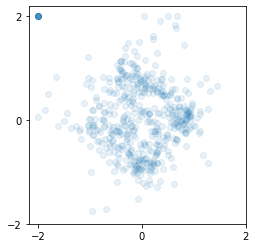

In [ ]:
plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
plt.scatter(new_s[:, 0], new_s[:, 1], alpha=0.1) #plot 1st row as x values and 2nd row as y values on the plot
plt.xticks([-2, 0, 2])
plt.yticks([-2, 0, 2])
plt.show()

In [ ]:
t_Q1(jnp.array([0.0, 0.8]))

Array([1317060.5], dtype=float32)

In [ ]:
c_Q1(jnp.array([0.0, 0.8]))

Array([23446844.], dtype=float32)

In [ ]:
t_Q2(jnp.array([0.0, 0.8]))

Array([1286689.8], dtype=float32)

In [ ]:
c_Q2(jnp.array([0.0, 0.8]))

Array([22416152.], dtype=float32)

In [ ]:
t_Q1(jnp.array([0.8, 0.0]))

Array([261.67404], dtype=float32)

In [ ]:
c_Q1(jnp.array([0.8, 0.0]))

Array([267.49957], dtype=float32)

In [ ]:
t_Q2(jnp.array([0.8, 0.0]))

Array([441.79007], dtype=float32)

In [ ]:
c_Q1(jnp.array([0.8, 0.0]))

Array([267.49957], dtype=float32)